In [2]:
import torch 
import xarray as xr
import os
import matplotlib.pyplot as plt

In [11]:
root="/r/scratch/users/mschillinger/data/cordexbench/"
domain="ALPS"
training_experiment = 'Emulator_hist_future'
mode = "train" 
if mode == "train":
    folder = "train"
else:
    raise ValueError("In DownscalingDatasetNormed: mode not recognised")
        
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ':
    gcm_name = 'ACCESS-CM2'
DATA_PATH = root + f"/{domain}/{domain}_domain"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'



Processing pr
torch.Size([14610, 128, 128])
Processing tasmax
torch.Size([14610, 128, 128])


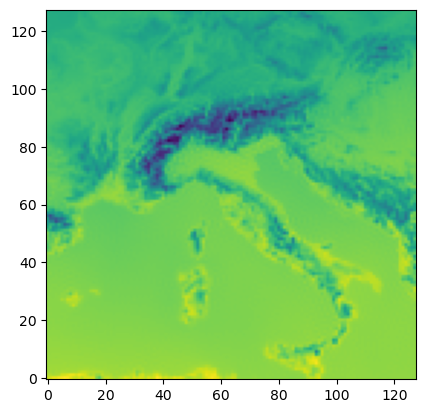

In [14]:
hr_ds = xr.open_dataset(hr_path)
for data_type in ["pr", "tasmax"]:
    print(f"Processing {data_type}")
    hr_data = torch.from_numpy(hr_ds[data_type].data)
    print(hr_data.shape)
    if data_type in ["pr"]:
        hr_data = torch.sqrt(hr_data)

    # COMPUTE NORM STATS        
    hr_std_all = torch.std(hr_data)
    hr_mean_all = torch.mean(hr_data)

    if data_type in ["pr"]:
        name_str = "_sqrt"
    else:
        name_str = ""

    file_base = f"{training_experiment}_{data_type}_{gcm_name}_{period_training}{name_str}"

    torch.save({"mean": hr_mean_all, "std": hr_std_all},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_full-data_{file_base}.pt"))

    hr_std_pw = torch.std(hr_data, dim=0)
    hr_mean_pw = torch.mean(hr_data, dim=0)

    torch.save({"mean": hr_mean_pw, "std": hr_std_pw},
        os.path.join(root, domain, "norm_stats", f"hr_norm_stats_pixelwise_{file_base}.pt"))

    hr_norm = (hr_data - hr_mean_pw) / hr_std_pw
    plt.imshow(hr_norm[0, :, :].detach().numpy(), origin='lower')

    plt.imshow(hr_mean_pw.detach().numpy(), origin='lower')